In [13]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt 
import time
seconds = time.time()
%matplotlib inline

In [14]:

##  CICIDS2017 csv files are required for the operation of the program.
##  These files must be located under the "CSVs" folder in the same directory as the program.



##  The purpose of this program is to clear the csv files containing CICIDS2017 data from errors.
##  the faults observed are:
##      1-   288602 of the entries in the file "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv" are empty / meaningless.
##                   (e.g. ",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,")
##
##      2-  In the original csv files, while describing the Web Attack types such as Brute Force, XSS, Sql Injection, the character used is not recognized
##                    by the Python-Pandas library and leads to the error.
##                    this character ("–", Unicode code:8211) has been changed with another character ("-", Unicode code:45) to correct the error.
##
##   After the error correction, all the csv files were made into a single file (all_date.csv) to make it easier to process.

def preprocess():

    print("This process may take 5 to 10 minutes, depending on the performance of your computer.\n\n\n")
    number="0123456789"
    # CSV files names:
    csv_files=["Monday-WorkingHours.pcap_ISCX",
            "Tuesday-WorkingHours.pcap_ISCX",
            "Wednesday-workingHours.pcap_ISCX",
            "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX",
            "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX",
            "Friday-WorkingHours-Morning.pcap_ISCX",
            "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX",
            "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX",]

    # Headers of column
    main_labels=["Flow ID","Source IP","Source Port","Destination IP","Destination Port","Protocol","Timestamp","Flow Duration","Total Fwd Packets",
    "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
    "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
    "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
    "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
    "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
    "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
    "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","faulty-Fwd Header Length","Fwd Avg Bytes/Bulk",
    "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
    "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
    "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min","Idle Mean","Idle Std","Idle Max","Idle Min","Label","External IP"]

    main_labels2=main_labels
    main_labels=( ",".join( i for i in main_labels ) )
    main_labels=main_labels+"\n"
    flag=True
    for i in range(len(csv_files)):
        ths = open(str(i)+".csv", "w")
        ths.write(main_labels)
        with open("./CSVs/"+csv_files[i]+".csv", "r") as file:
            while True:
                try:
                    line=file.readline()
                    if  line[0] in number:# this line eliminates the headers of CSV files and incomplete streams .
                        if " – " in str(line): ##  if there is "–" character ("–", Unicode code:8211) in the flow ,  it will be chanced with "-" character ( Unicode code:45).
                            line=(str(line).replace(" – "," - "))
                        line=(str(line).replace("inf","0"))
                        line=(str(line).replace("Infinity","0"))
                        line=(str(line).replace("NaN","0"))
                        
                        ths.write(str(line))
                    else:
                        continue                       
                except:
                    break
        ths.close()
    
    
        df=pd.read_csv(str(i)+".csv",low_memory=False)
        df = df.fillna(0).infer_objects()

        if 'Label' in df.columns:
            df['Label'] = df['Label'].astype(str)

        string_features=["Flow Bytes/s","Flow Packets/s"]
        for ii in string_features: #Some data in the "Flow Bytes / s" and "Flow Packets / s" columns are not numeric. Fixing this bug in this loop
            df[ii]=df[ii].replace('Infinity', -1)
            df[ii]=df[ii].replace('NaN', 0)
            number_or_not=[]
            for iii in df[ii]:
                try:
                    k=int(float(iii))
                    number_or_not.append(int(k))
                except:
                    number_or_not.append(iii)
            df[ii]=number_or_not



        string_features=[]
        for j in main_labels2: # In this section, non-numeric (string and / or categorical) properties (columns) are detected.
            if df[j].dtype=="object":
                string_features.append(j)

        # print(string_features)
        # try:
        #     string_features.remove('Label')#The "Label" property was removed from the list. Because it has to remain "categorical" for using with different machine learning approach.
        # except:
        #     print("error!")

        # print(f"Dtypes of columns in file {csv_files[i]}:\n{df.dtypes}\n")

        print(f"String features before removing 'Label': {string_features}")
        if 'Label' in string_features:
            string_features.remove('Label')
        else:
            print("'Label' column not found in string_features.")

        labelencoder_X = preprocessing.LabelEncoder()



        for ii in string_features: ## In this loop, non-numeric (string and/or categorical) properties converted to numeric features.
            try:
                df[ii]=labelencoder_X.fit_transform(df[ii])
            except:
                df[ii]=df[ii].replace('Infinity', -1)
        df=df.drop(main_labels2[61], axis=1) ## Column 61 is deleted because it is unnecessary, column 41 ("Fwd Header Length" feature) had be mistakenly rewritten.



        ##All CSV files are merged into a single file.
        if flag:
            # df.to_csv('all_data.csv' ,index = False)
            df.to_csv('all_data_default.csv' ,index = False)
            flag=False
        else:
            # df.to_csv('all_data.csv' ,index = False,header=False,mode="a")
            df.to_csv('all_data_default.csv' ,index = False,header=False,mode="a")
        os.remove(str(i)+".csv")

        print("The pre-processing phase of the ",csv_files[i]," file is completed.\n")

preprocess()
# total size 2672997
dataset_sample_size=700000
all_data = pd.read_csv('all_data_default.csv')
sample_df = all_data.sample(n=dataset_sample_size, random_state=42)
print("SAMPLE SHAPE:", sample_df.shape)
sample_df.to_csv('all_data.csv', index=False)

print("Total operation time: = ",time.time()- seconds ,"seconds")
    


This process may take 5 to 10 minutes, depending on the performance of your computer.



String features before removing 'Label': ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'Label']
The pre-processing phase of the  Monday-WorkingHours.pcap_ISCX  file is completed.

String features before removing 'Label': ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'Label']
The pre-processing phase of the  Tuesday-WorkingHours.pcap_ISCX  file is completed.

String features before removing 'Label': ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'Label']
The pre-processing phase of the  Wednesday-workingHours.pcap_ISCX  file is completed.

String features before removing 'Label': ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'Label']
The pre-processing phase of the  Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX  file is completed.

String features before removing 'Label': ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'Label']
The pre-processing p

/tmp/ipykernel_88463/2215260672.py:138: DtypeWarning: Columns (84) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv('all_data_default.csv')


Original shape: (700000, 85)
Total operation time: =  94.1962342262268 seconds


In [12]:
# def skewDataset(FTP_Patator, SSH_Patator, DoS_slowloris, DoS_Slowhttptest, DoS_Hulk, DoS_GoldenEye, Heartbleed, Infiltration, Bot, PortScan, DDoS, BENIGN_ratio):

#     df = pd.read_csv('all_data_default.csv')
#     print("Original shape:", df.shape)
#     print("Unique labels:", df['Label'].unique())
#     print(df['Label'].value_counts())

#     params = {
#         'FTP-Patator': FTP_Patator,
#         'SSH-Patator': SSH_Patator,
#         'DoS slowloris': DoS_slowloris,
#         'DoS Slowhttptest': DoS_Slowhttptest,
#         'DoS Hulk': DoS_Hulk,
#         'DoS GoldenEye': DoS_GoldenEye,
#         'Heartbleed': Heartbleed,
#         'Infiltration': Infiltration,
#         'Bot': Bot,
#         'PortScan': PortScan,
#         'DDoS': DDoS
#     }

#     reduced_dfs = []

#     for label, keep in params.items():
#         if keep:

#             reduced_dfs.append(df[df['Label'] == label])
#         else:

#             label_df = df[df['Label'] == label]
#             keep_size = int(0.1 * len(label_df))
#             if keep_size > 0:
#                 reduced_dfs.append(label_df.sample(keep_size, random_state=1))

#     if BENIGN_ratio < 1.0:
#         benign_df = df[df['Label'] == 'BENIGN']
#         keep_size = int(BENIGN_ratio * len(benign_df))
#         if keep_size > 0:
#             reduced_dfs.append(benign_df.sample(keep_size, random_state=1))
#     else:

#         reduced_dfs.append(df[df['Label'] == 'BENIGN'])

#     reduced_df = pd.concat(reduced_dfs).reset_index(drop=True)

#     print("\n///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////\n")
    
#     print("Reduced shape:", reduced_df.shape)
#     print("Unique labels after reduction:", reduced_df['Label'].unique())
#     print(reduced_df['Label'].value_counts())

#     return reduced_df

# reduced_df = skewDataset(FTP_Patator=False, 
#                          SSH_Patator=False, 
#                          DoS_slowloris=False, 
#                          DoS_Slowhttptest=False, 
#                          DoS_Hulk=False, 
#                          DoS_GoldenEye=False, 
#                          Heartbleed=False, 
#                          Infiltration=False, 
#                          Bot=False, 
#                          PortScan=False, 
#                          DDoS=True,
#                          BENIGN_ratio=0.3)

# reduced_df.to_csv('all_data.csv', index=False)


Original shape: (2672997, 85)
Unique labels: ['BENIGN' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris' 'DoS Slowhttptest'
 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed' 'Infiltration' 'Bot' 'PortScan'
 'DDoS']
Label
BENIGN              2117531
DoS Hulk             231073
PortScan             158930
DDoS                 128027
DoS GoldenEye         10293
FTP-Patator            7938
SSH-Patator            5897
DoS slowloris          5796
DoS Slowhttptest       5499
Bot                    1966
Infiltration             36
Heartbleed               11
Name: count, dtype: int64

///////////////////////////////////////////////////////////////////////////////

Reduced shape: (806025, 85)
Unique labels after reduction: ['FTP-Patator' 'SSH-Patator' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk'
 'DoS GoldenEye' 'Heartbleed' 'Infiltration' 'Bot' 'PortScan' 'DDoS'
 'BENIGN']
Label
BENIGN              635259
DDoS                128027
DoS Hulk             23107
PortScan             15893
DoS GoldenEye         

Label
BENIGN              577096
DoS Hulk             60454
PortScan             41689
DDoS                 11023
DoS GoldenEye         2667
FTP-Patator           2124
SSH-Patator           1519
DoS slowloris         1484
DoS Slowhttptest      1436
Bot                    495
Infiltration            11
Heartbleed               2
Name: count, dtype: int64


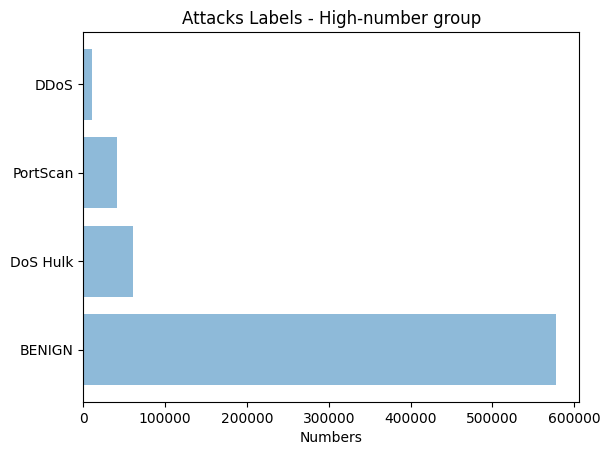

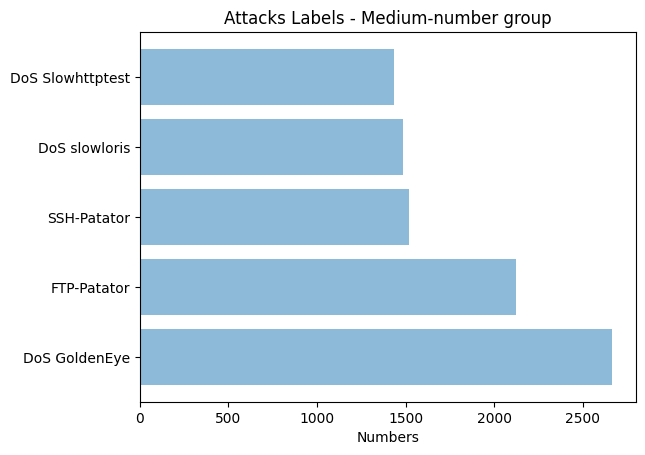

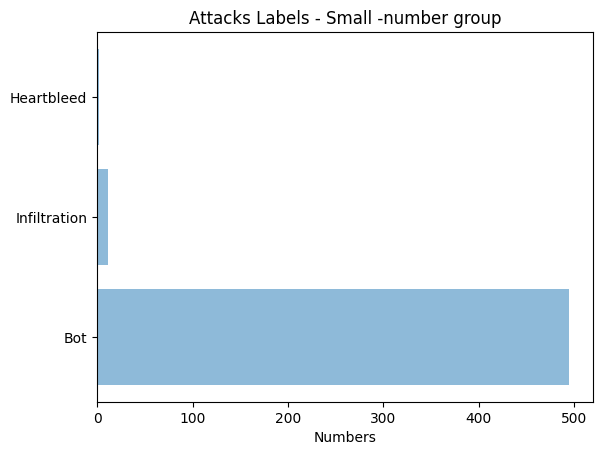

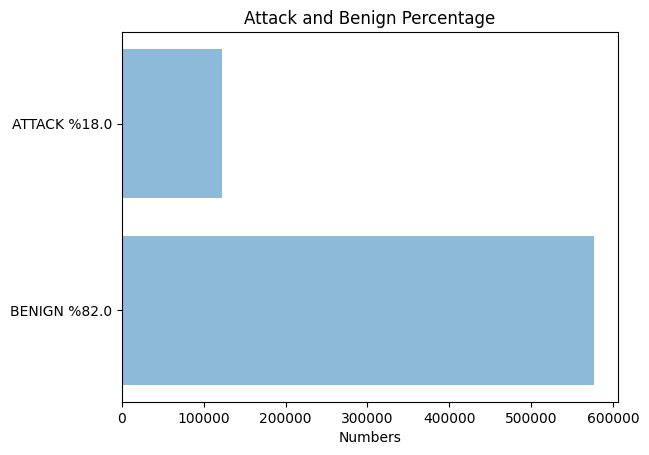

Total operation time: =  168.2602014541626 seconds


In [15]:
##  all_data.csv files is required for the operation of the program.
##  all_data.csv file must be located in the same directory as the program.



##  The purpose of this program is to provide statistics about the data contained in the dataset.
##  Considering that some of the data are very large and some of them are very small, the graphics are created in three separate groups, so that all data can be seen:
##          big: labels with more than 11000 numbers
##          medium: labels with numbers between 600 and 11000
##          small: labels with fewer than 600 numbers
##  
##  In the last graphics, the rates of all attacks and normal behaviors are given.

#  graph creation function
def graph(objects,performance,x_label,y_label):
    y_pos = np.arange(len(objects))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel(x_label)
    plt.title(y_label)
    plt.show()


df=pd.read_csv('all_data.csv', usecols=["Label"])
print(df.iloc[:,0].value_counts())
a=(df.iloc[:,0].value_counts())


key=a.keys()
values=a.values
small_labels=[]
small_values=[]
big_labels=[]
big_values=[]
medium_labels=[]
medium_values=[]
attacak=0
benign=0


## In this section, the attacks are grouped under 3 groups,
## so that all values can be seen on the graph.
for i in range(0,len(values)):
    if values[i]>11000:
        big_labels.append(str(key[i]))
        big_values.append(values[i])
    elif values[i]<600:
        small_labels.append(str(key[i]))
        small_values.append(values[i]) 
    else:
        medium_labels.append(str(key[i]))
        medium_values.append(values[i])

    if str(key[i])=="BENIGN":
        benign+=values[i]
    else:
        attacak+=values[i]
        
key =[benign,attacak]


#functions are called to create a chartes
labels=["BENIGN %"+str(round(benign/(benign+attacak),2)*100),
        "ATTACK %"+str(round(attacak/(benign+attacak),2)*100)]
graph(big_labels,big_values,"Numbers","Attacks Labels - High-number group")
graph(medium_labels,medium_values,"Numbers","Attacks Labels - Medium-number group")
graph(small_labels,small_values,"Numbers","Attacks Labels - Small -number group")
graph(labels,key,"Numbers","Attack and Benign Percentage")

print("Total operation time: = ",time.time()- seconds ,"seconds")